In [1]:
import numpy as np
import cv2
import pandas as pd
import glob
from sklearn import svm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from skimage.feature import hog
from skimage import data, exposure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def boundingBoxFromXML(path):
    '''takes and XML file path, returns the four corners of a bounding box
        depends on python xml 
        import xml.etree.ElementTree as ET
    '''
    
    #import the xml file and set a root
    tree = ET.parse(path)
    root = tree.getroot()
    
    #navigate to the bounding box
    root = root.find('object')    
    root = root.find('bndbox')
    
    #get the corners, order is xmin, ymin, xmax, ymax
    output = []
    for child in root:
        output.append( int(child.text) )
        
    return output

def getColorHistogram_X(image, channel):
    '''Takes and image and a target channel
        returns a color histrogam along the width of the image
    '''
    
    #container for results
    hist = []

    #loop over all the cols
    for i in range(image.shape[1]):

        #get the ith column
        col = image[:,i]

        #use numpy to get the sum of each channel for this col
        counts = np.sum(col, axis = 0)

        #return only the channel requested
        hist.append(counts[channel])

    return hist

def getColorHistogram_Y(image, channel):
    '''Takes and image and a target channel
        returns a color histrogam along the height of the image
    '''
    
    #container for results
    hist = []

    #loop over all the cols
    for i in range(image.shape[0]):

        #get the ith column
        col = image[i,:]

        #use numpy to get the sum of each channel for this col
        counts = np.sum(col, axis = 0)

        #return only the channel requested
        hist.append(counts[channel])

    return hist

In [3]:
#first read the image file paths
shipImagePaths = glob.glob("MASATI-v2/ship/*.png")

#next read the xml label file paths
shipLabelPaths = glob.glob("MASATI-v2/ship_labels/*.xml")

#container for ship images
imagesOfShips = []

#next loop over all the images and parse the XML file along the way
for i in range(1000):  #for now just 100 images
    
    #read the image with opencv
    image = cv2.imread(shipImagePaths[i])
    
    #parse the XML file to get the bounding box
    box = boundingBoxFromXML(shipLabelPaths[i])
    
    #crop out the ship using numpy
    imageCropped = image[box[1]:box[3], box[0]:box[2]] #[y:y+h, x:x+w] 
    
    #record the image
    imagesOfShips.append(imageCropped)

In [4]:
#read the ocean image paths
oceanImagePaths = glob.glob("MASATI-v2/water/*.png")

#container for ocean images
imagesOfOcean = []

#loop 
for i in range(1000):
    
    #read in the image with opencv
    imagesOfOcean.append(cv2.imread(oceanImagePaths[i]))

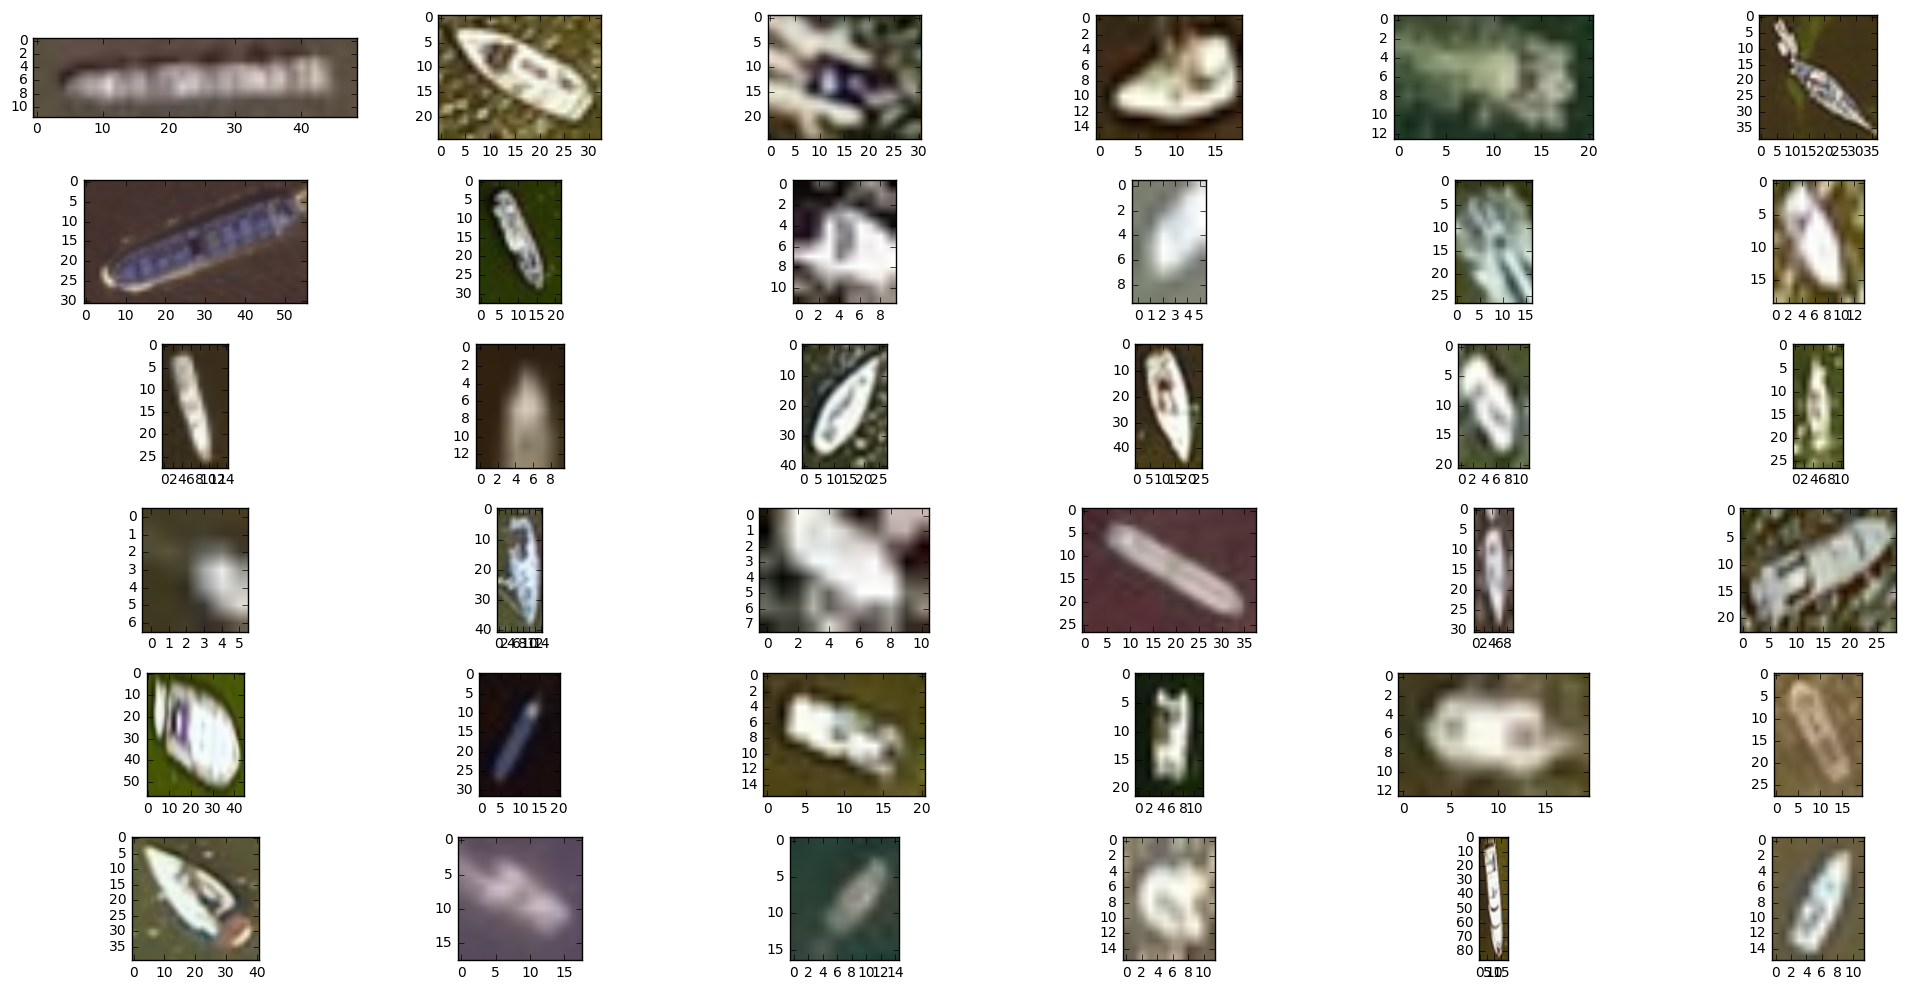

In [5]:
#plt subplot setup
fig, axs = plt.subplots(6, 6, figsize=(20, 10)) 

#loop to plot some random images for visulaztion purposes
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(imagesOfShips[np.random.randint(len(imagesOfShips))])
    
plt.tight_layout()
plt.show()

In [13]:
#containers for data
features = []
labels = []

#loop over the ships to make feature vectors
for i in range(len(imagesOfShips)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfShips[i], (30,30))
    
    #get the x-axis histograms
    redX = getColorHistogram_X(image, 0)
    greenX = getColorHistogram_X(image, 1)
    blueX = getColorHistogram_X(image, 2)
    
    #get the y-axis histograms
    redY = getColorHistogram_Y(image, 0)
    greenY = getColorHistogram_Y(image, 1)
    blueY = getColorHistogram_Y(image, 2)
    
    #compile a feature vector
    featureVector = np.array(redX + greenX + blueX + redY + greenY + blueY)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(1)
    
#loop over the ocean to make feature vectors
for i in range(len(imagesOfOcean)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfOcean[i], (30,30))
    
    #get the x-axis histograms
    redX = getColorHistogram_X(image, 0)
    greenX = getColorHistogram_X(image, 1)
    blueX = getColorHistogram_X(image, 2)
    
    #get the y-axis histograms
    redY = getColorHistogram_Y(image, 0)
    greenY = getColorHistogram_Y(image, 1)
    blueY = getColorHistogram_Y(image, 2)
    
    #compile a feature vector
    featureVector = np.array(redX + greenX + blueX + redY + greenY + blueY)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(0)
    
#normalize the dataset
maxSet = np.max(features)
minSet = np.min(features)
for i in range(len(features)):
    
    #use min subtraction and max division norm
    features[i] = (features[i] - minSet) / (maxSet - minSet)
    
#shuffle the data
features, labels = shuffle(features, labels)

#split into training and validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

## Model training with color histograms
Here we will use a two layer network and search for the best combination of network sizes using nested for loops

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


(6, 6) 0.98125


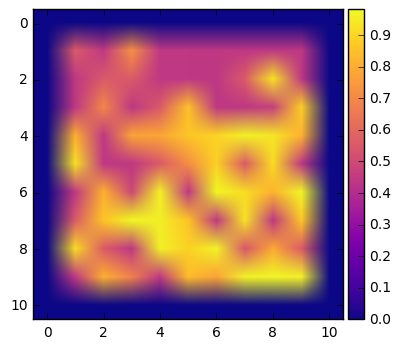

In [14]:
#layers to explore
explore = [1, 10]

# Track the best performing size.
bestHiddenLayerDim=None
bestHiddenLayerPerformance=0

#array to track performance as an easy plot
per = np.zeros((11,11))

#loop over the layer candiates
for layer1Size in range(explore[0], explore[1]):
    for layer2Size in range(explore[0], explore[1]):
        
        #print(layer1Size, layer2Size)
        
        #define a network
        clf = MLPClassifier(alpha=1e-5,
                    max_iter=10,
                     hidden_layer_sizes=(layer1Size, layer2Size), random_state=1)
        
        #train this network
        clf.fit(X_train, y_train)
        
        #make some predictions with the network
        predictions = clf.predict(X_test)
        
        #get the accuracy
        score = accuracy_score(y_test, predictions)
        
        #update the array
        per[layer1Size][layer2Size] = score
        
#get the best layer combination
best = np.unravel_index(np.argmax(per, axis=None), per.shape)
print(best, np.max(per))

#plot it with the colorbar
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(per, cmap='plasma')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Next we will tune learning rate and training iterations
Again we will use a nested for loop here to find the best learning rate, iteration combo

In [15]:
#layers to explore
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

#array to track performance as an easy plot
per = np.zeros((100,len(learning_rates)))

#loop learning rate and epochs
for max_iter_i in range(10,100,10):
    for i in range(len(learning_rates)):
        
        #print(max_iter_i, i)
        
        #define a network
        clf = MLPClassifier(learning_rate_init= learning_rates[i],
                    max_iter=max_iter_i,
                     hidden_layer_sizes=(best[0], best[1]), random_state=1)
        
        #train this network
        clf.fit(X_train, y_train)
        
        #make some predictions with the network
        predictions = clf.predict(X_test)
        
        #get the accuracy
        score = accuracy_score(y_test, predictions)
        
        #update the array
        per[max_iter_i, i] = score
        
#get the best layer combination
best = np.unravel_index(np.argmax(per, axis=None), per.shape)
print(best[0], learning_rates[best[1]], np.max(per))

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


20 0.01 0.9875


## Lastly tune alpha, the regularzation parameter

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


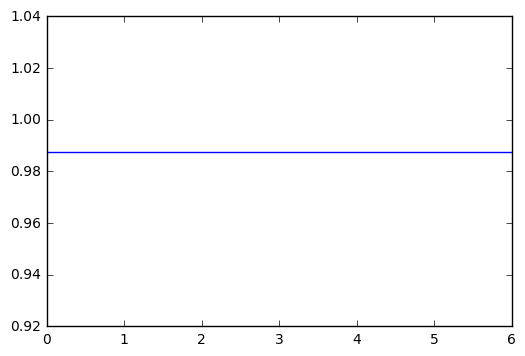

In [16]:
#layers to explore
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
acc = []
i_s = []

#loop alpha
for i in range(len(alphas)):
    
    i_s.append(i)

    #print(layer1Size, layer2Size)

    #define a network
    clf = MLPClassifier(alpha = alphas[i],
               learning_rate_init = .01,
                max_iter = 20,
                 hidden_layer_sizes=(6, 6), random_state=1)

    #train this network
    clf.fit(X_train, y_train)

    #make some predictions with the network
    predictions = clf.predict(X_test)

    #get the accuracy
    score = accuracy_score(y_test, predictions)

    #update the array
    acc.append(score)
        
#plot the results
plt.plot(i_s, acc)
#plt.ylim(.97, .985)
plt.show()

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


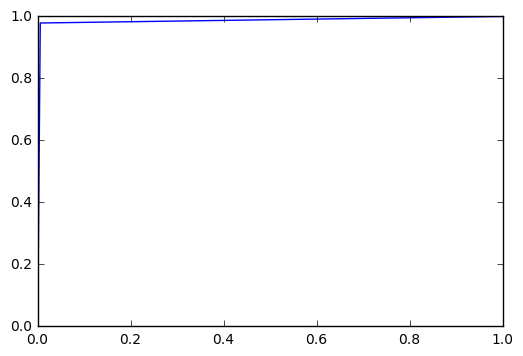

In [18]:
#train the "best" model
clf = MLPClassifier(alpha = alphas[np.argmax(acc)],
               learning_rate_init = .001,
                max_iter = 80,
                 hidden_layer_sizes=(6, 9), random_state=1)

clf.fit(X_train, y_train)

#make some predictions with the network
predictions = clf.predict(X_test)

#plot ROC and save out info
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
a1 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr)
plt.show()

#save out
np.save("NN_HIST.npy", np.column_stack((fpr, tpr)))

### HOG
Here we will explore the use of histogram oritened gradient as a feature vector, comparing to the use of color historgrams.

The "Histogram Oriented Gradient" of a paricular image is an array of features
that indicate the direction (or gradient) of the color channels in the image.
It is the same as applying a [-1, 0, 1] kernel filter on the image.

We do not want the gradient for every pixel, it would be far too
sensitive to noise and too big of an input for training an ANN.
Break up the image into cells, and get a histogram of numberOfBins
where each bin contains the sum magnitude for the angle cooresponding
to that bin.

The hog will normalize areas of cells within a specified "block",
this helps if there is differences in lighting. For our purposes,
leaving this at 1, 1 and not normalizing should be ok.

We need to resize before getting the HOG so that our model can be trained
on consistent images.

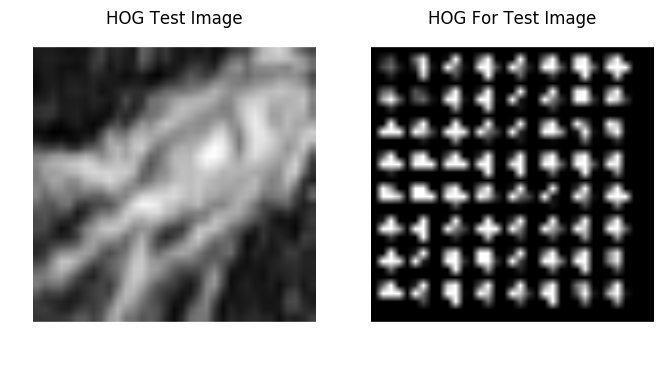

In [19]:
#pull a test image and convert it to gray
testImage = imagesOfShips[3]
testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)

features, hogImage = hog(testImage, visualise= True, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.set_title('HOG Test Image')
ax1.imshow(testImage, cmap='gray')


# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hogImage, in_range=(0, 10))

ax2.axis('off')
ax2.set_title('HOG For Test Image')
ax2.imshow(hog_image_rescaled, cmap='gray')
plt.show()

## Train our model using histogram oriented gradients.
First we need to get the new feature vectors

In [20]:
#containters for features and labels
features = []
labels = []

#HOG parameters
cellSize = (4, 4)
blockSize = (2, 2)

#loop over the ships to make feature vectors
for i in range(len(imagesOfShips)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfShips[i], (30,30))
    
    #Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the histogram oriented gradient for that image.
    imageHOG = hog(image, orientations=8, pixels_per_cell=cellSize,
                    cells_per_block=blockSize)
    
    #compile a feature vector
    featureVector = np.array(imageHOG)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(1)
    
#loop over the ocean to make feature vectors
for i in range(len(imagesOfOcean)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfOcean[i], (30,30))
    
    #Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the histogram oriented gradient for that image.
    imageHOG = hog(image, orientations=8, pixels_per_cell=cellSize,
                    cells_per_block=blockSize)
    
    #compile a feature vector
    featureVector = np.array(imageHOG)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(0)

#normalize the dataset
maxSet = np.max(features)
minSet = np.min(features)
for i in range(len(features)):
    
    #use min subtraction and max division norm
    features[i] = (features[i] - minSet) / (maxSet - minSet)
    
#shuffle the data
features, labels = shuffle(features, labels)

#split into training and validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

## Build a network
Once again use nested for loops to find the best two layer network 

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


(6, 4) 0.96875


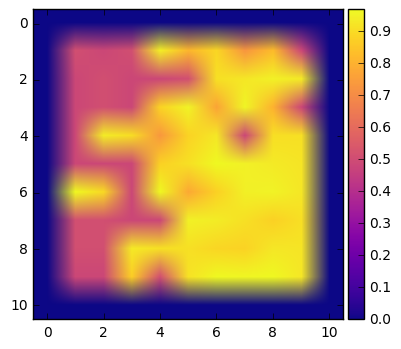

In [21]:
#layers to explore
explore = [1, 10]

# Track the best performing size.
bestHiddenLayerDim=None
bestHiddenLayerPerformance=0

#array to track performance as an easy plot
per = np.zeros((11,11))

#loop over the layer candiates
for layer1Size in range(explore[0], explore[1]):
    for layer2Size in range(explore[0], explore[1]):
        
        #print(layer1Size, layer2Size)
        
        #define a network
        clf = MLPClassifier(alpha=1e-5,
                    max_iter=10,
                     hidden_layer_sizes=(layer1Size, layer2Size), random_state=1)
        
        #train this network
        clf.fit(X_train, y_train)
        
        #make some predictions with the network
        predictions = clf.predict(X_test)
        
        #get the accuracy
        score = accuracy_score(y_test, predictions)
        
        #update the array
        per[layer1Size, layer2Size] = score
        
#get the best layer combination
best = np.unravel_index(np.argmax(per, axis=None), per.shape)
print(best, np.max(per))

#plot it with the colorbar
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(per, cmap='plasma')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Tune learning rate and epochs

In [22]:
#layers to explore
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

#array to track performance as an easy plot
per = np.zeros((100,len(learning_rates)))

#loop learning rate and epochs
for max_iter_i in range(10,100,10):
    for i in range(len(learning_rates)):
        
        #print(layer1Size, layer2Size)
        
        #define a network
        clf = MLPClassifier(learning_rate_init= learning_rates[i],
                    max_iter=max_iter_i,
                     hidden_layer_sizes=(6, 4), random_state=1)
        
        #train this network
        clf.fit(X_train, y_train)
        
        #make some predictions with the network
        predictions = clf.predict(X_test)
        
        #get the accuracy
        score = accuracy_score(y_test, predictions)
        
        #update the array
        per[max_iter_i, i] = score
        
#get the best layer combination
best = np.unravel_index(np.argmax(per, axis=None), per.shape)
print(best[0], learning_rates[best[1]], np.max(per))

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


20 0.001 0.975


## Lastly tune alpha


/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


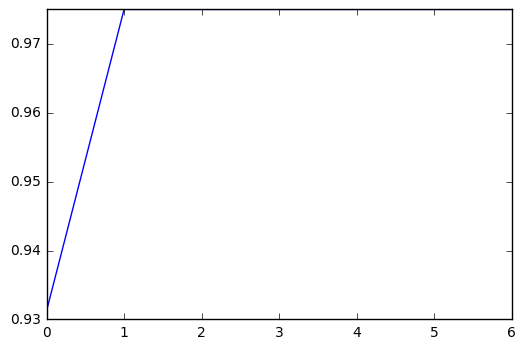

In [23]:
#layers to explore
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
acc = []
i_s = []

#loop alpha
for i in range(len(alphas)):
    
    i_s.append(i)

    #print(layer1Size, layer2Size)

    #define a network
    clf = MLPClassifier(alpha = alphas[i],
               learning_rate_init = 0.001,
                max_iter = 20,
                 hidden_layer_sizes=(6, 4), random_state=1)

    #train this network
    clf.fit(X_train, y_train)

    #make some predictions with the network
    predictions = clf.predict(X_test)

    #get the accuracy
    score = accuracy_score(y_test, predictions)

    #update the array
    acc.append(score)
        
#plot the results
plt.plot(i_s, acc)
#plt.ylim(.97, .985)
plt.show()

/Users/johnmcconnell/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


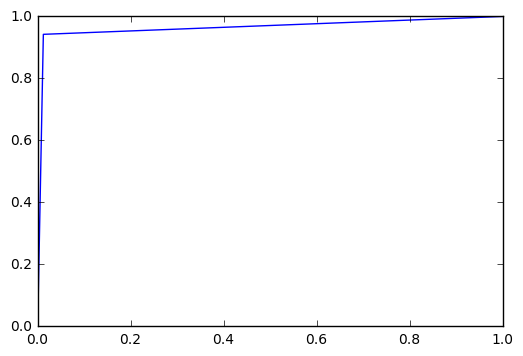

In [25]:
#train the "best" model
clf = MLPClassifier(alpha = alphas[np.argmax(acc)],
           learning_rate_init = .0001,
            max_iter = 70,
             hidden_layer_sizes=(3, 7), random_state=1)

clf.fit(X_train, y_train)

#make some predictions with the network
predictions = clf.predict(X_test)

#plot ROC and save out info
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
a1 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr)
plt.show()

#save out
np.save("NN_HOG.npy", np.column_stack((fpr, tpr)))

In [ ]:
# Create the best network based on our optimized hyper parameters
clf = MLPClassifier(alpha=1e-5,
            max_iter=500,
             hidden_layer_sizes=(bestHiddenLayerDim[0], bestHiddenLayerDim[1]), random_state=1)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

#plot the curve
plt.plot(fpr, tpr)
plt.title("ROC Curve For Baseline Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()